# View Landsat 8 Imagery

Get landsat 8 images for a given time period and lat/long extents, choose a image and plot a false color composite. Save plots, export xarray dataset to netCDF and translate to geotiff files on the command line.

Authorship: Bex Dunn, Mike Barnes, Claire Krause, Damien Ayers, Sivaprasad Arapaut

This notebook is derived from [View Landsat 8 imagery](http://geoscienceaustralia.github.io/digitalearthau/notebooks/products/RetrieveLandsat8ViewAndExport.html) and can replace it.

Instead of using GA's internally developed modules, the entire code is using functions from datacube libraries. It makes thios document suitable for general use.

## Step-by-step instructions
Let us go through the process step by step.

### 1. Import modules and libraries
All the modules and libraries below are standard ones available to all users. 

In [2]:
%pylab notebook

import datacube
from datacube.storage import masking
from datacube.storage.storage import write_dataset_to_netcdf

import xarray as xr
import numpy as np
import os
import rasterio
dc = datacube.Datacube(app='dc-plot landsat  FalseColour')

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 2. Create the required functions 

We need a function to write the data in netCDF format, and one to delete a file before re-creating it. NetCDF (Network Common Data Form) is a set of software libraries and self-describing, machine-independent data formats that support the creation, access, and sharing of array-oriented scientific data. [Panoply](https://www.giss.nasa.gov/tools/panoply/) is a netCDF file viewer developed at the NASA Goddard Institute for Space Studies which focuses on presentation of geo-gridded data. 

In [3]:
def write_your_netcdf(data, dataset_name, filename, crs):
    #turn array into dataset so we can write the netcdf
    if isinstance(data,xr.DataArray):
        dataset= data.to_dataset(name=dataset_name)
    elif isinstance(data,xr.Dataset):
        dataset = data
    else:
        print('your data might be the wrong type, it is: '+type(data))
    print (dataset.attrs)
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))  
        
def delete_a_file(filename):
    try:
        os.remove(filename)
    except OSError:
        pass


### 3. The datacube query

**Edit the start and end dates and spatial bounds here if you wish**

The date range determines the number of layers(?) of data to be retrieved. About 16 days form one layer and, if you select more than one layer, there may be some problems down the track when creating a TIFF file. The current code can only plot one layer at a time. Another doc will describe how to plot several layes together.

In [50]:
#Temporal range is defined
start_of_epoch = '2015-09-01'
end_of_epoch =  '2015-09-15'

#Wavelengths/bands of interest are defined
bands_of_interest = ['swir1', 'nir', 'green']

#Sensors of interest are defined
sensors = ['ls8']
product = 'nbar'

#Create bounding box
lat_max = -35.25
lat_min = -35.35
lon_max = 149.17
lon_min = 149.05

#Create query
query = {'time': (start_of_epoch, end_of_epoch)}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
print(query)

{'time': ('2015-09-01', '2015-09-15'), 'x': (149.05, 149.17), 'y': (-35.25, -35.35)}


### 4. Run the datacube extraction
**This may take some time. Be patient!**

The next two blocks of code are to extract the data.

**Firstly, we define the product and sensor (satellite)**

In [51]:
sensor = sensors[0]
filter_pq=True
product_name = '{}_{}_albers'.format(sensor, product)
mask_product = '{}_{}_albers'.format(sensor, 'pq')

**Secondly, we get the data (in the variable, ds) which will be used by the plotting functions later. **

In [52]:
ds = dc.load(product=product_name, group_by='solar_day', **query)
ds
ds.attrs['affine'] = ds.affine

### Extract the PQ data to use as mask. 
If pixel quality filtering is enabled, extract the PQ data to use as mask. This is stored in exactly the same format as the main data, but will be used to mask selected pixels. For example, if the cloud covered regions are to be masked, then their values will be set as 'False'. 

In [53]:
if ds.variables:
    # If pixel quality filtering is enabled, extract PQ data to use as mask
    if filter_pq:
        sensor_pq = dc.load(product=mask_product, group_by='solar_day', **query)
        # If PQ call returns data, use to mask input data
        if sensor_pq.variables:
            good_quality = masking.make_mask(sensor_pq.pixelquality,
                                             cloud_acca='no_cloud',
                                             cloud_shadow_acca='no_cloud_shadow',
                                             cloud_shadow_fmask='no_cloud_shadow',
                                             cloud_fmask='no_cloud',
                                             blue_saturated=False,
                                             green_saturated=False,
                                             red_saturated=False,
                                             nir_saturated=False,
                                             swir1_saturated=False,
                                             swir2_saturated=False,
                                             contiguous=True)
            # Apply mask to preserve only good data
            ds = ds.where(good_quality)
            

### Create the image data to plot

In [54]:
time=0
bands = bands_of_interest
contrast_enhance=False
figsize=[10, 10]
title='My Plot'
projection='projected'
t, y, x = ds[bands[0]].shape
rawimg = np.zeros((y, x, 3), dtype=np.float32)
for i, colour in enumerate(bands):
    rawimg[:, :, i] = ds[colour][time].values
img_toshow = rawimg / 5000

### Plot the image

<IPython.core.display.Javascript object>


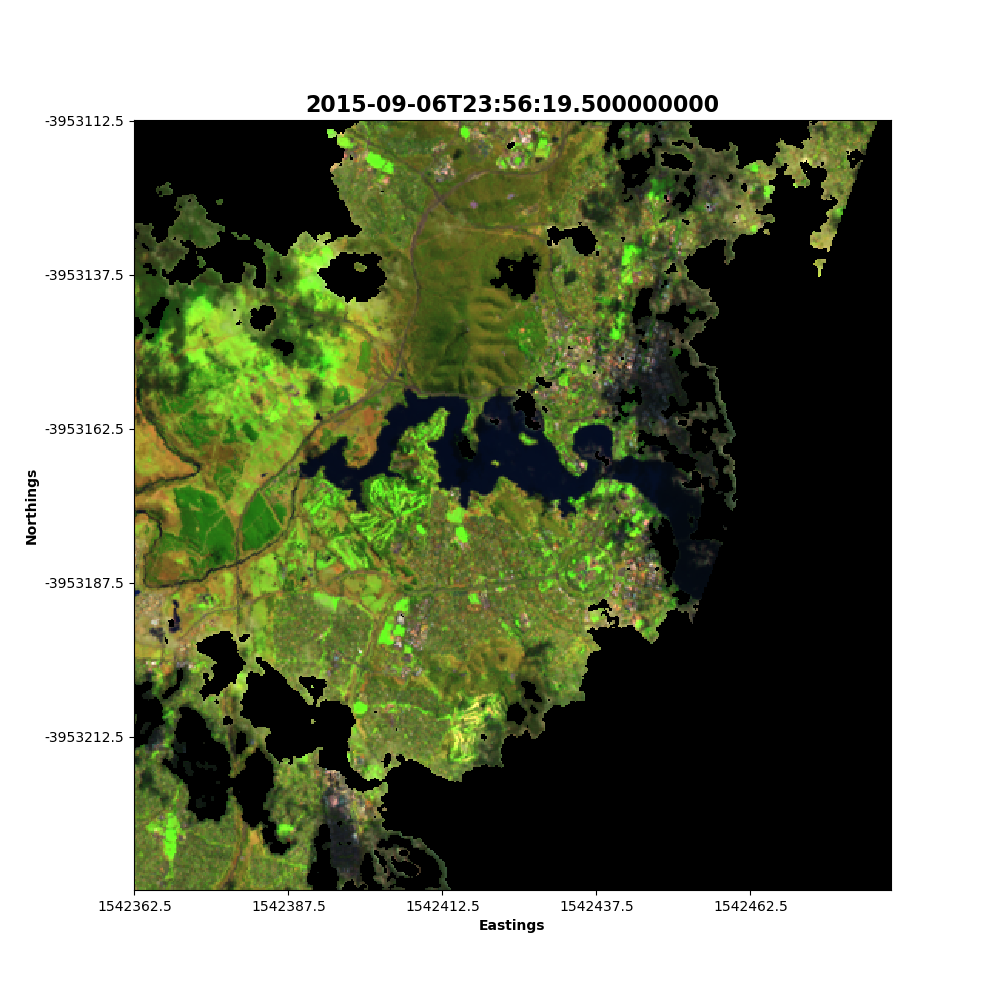

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0,0.5,'Northings')

In [55]:
fig = plt.figure(figsize=figsize)
plt.imshow(img_toshow)
ax = plt.gca()
ax.set_title(str(ds.time[time].values), fontweight='bold', fontsize=16)

ax.set_xticklabels(ds.x.values)
ax.set_yticklabels(ds.y.values)
ax.set_xlabel('Eastings', fontweight='bold')
ax.set_ylabel('Northings', fontweight='bold')
